# Protein Secondary Structure Prediction with Recurrent Neural Networks And GRUs

# Importing Required Libraries

In [106]:
%pip install -r requirements.txt

Processing c:\b\abs_98xvdek9qa\croot\aext-assistant_1734644152369\work (from -r requirements.txt (line 3))
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\b\\abs_98xvdek9qa\\croot\\aext-assistant_1734644152369\\work'



In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.utils.data as utils
from torch.nn.utils.rnn import pad_sequence ,pack_padded_sequence,pad_packed_sequence

import numpy as np
import random
import os
import math
import pickle
import time
import tqdm

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

### Set Random Number Initializers for Repeatability

In [108]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [109]:
#IMPORTANT HYPERPARAMETERS
BATCH_SIZE = 32 # Values you can try out: 64, 128, 1
LEARNING_RATE = 0.001 
EPOCHS = 100
DROPOUT = 0.2
HIDDEN_SIZE = 128
EMBEDDING_SIZE = 128
NUM_LAYERS =1 # Number of layers in the RNN
PATIENCE = 10 # Early stopping patience
MIN_DELTA = 0.001 # Minimum change in validation acc to qualify as an improvement

Our Targets are : 

'H' : α-helix , 3-helix , π-helix

'E' : β-strand , β-bridge

'C' : Loops and irregular elements , Turn , Bend

Residue names are alphabets corresponding to different amino acids ie "A" --> Alanine

In [110]:
target_names=["H","E","C"]
residue_names = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X','NoSeq']

#### Set device for the model to run on.
GPU is preferred as RNNs take longer to train.

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)
cpu = torch.device('cpu')

cuda


### Preprocessing the data
First, we need to define Dataset class in pytorch which must have 3 functions : __init__(), __getitem__(), __len__().

Now,our protein sequences are of different length. But, the batch we load will have fixed size. Hence, we take this size to be the size of the longest sequence in the batch and pad the shorter sequences.

In [112]:
def load_from_pkl(path):
    with open(path, 'rb') as f:
        var = pickle.load(f)
    return var

# class to index loaded dataset
class Dataset(data.Dataset):
    def __init__(self, path_to_pkl):
        self.data = load_from_pkl(path_to_pkl)
        self.ids = list(self.data.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id = self.ids[index]
        dict = self.data[id]
        seq = dict["sequence"]
        pssm = dict["pssm"]
        length = len(seq)
        
        secstr = dict["secstr"]
        secstr_q3 = dict["secstr_q3"]

        return id,seq,pssm,length,secstr,secstr_q3
    
# Helper Function to pad a batch of protein sequences.
def pad_batch(DataLoaderBatch):
    """
    DataLoaderBatch should be a list of (sequence, target, length) tuples...
    Returns a padded tensor of sequences sorted from longest to shortest, 
    """
    batch_size = len(DataLoaderBatch)
    batch_split = list(zip(*DataLoaderBatch))

    ids, seqs, pssms, lengths, secstrs, secstrs_q3 = batch_split[0], batch_split[1], batch_split[2] ,batch_split[3], batch_split[4], batch_split[5]
    max_length = max(lengths)

    padded_seqs = np.zeros((max_length, batch_size))
    padded_pssms = np.zeros((max_length,batch_size,22))
    padded_secstrs = np.ones((max_length,batch_size))*30
    padded_secstrs_q3 = np.ones((max_length,batch_size))*30
    
    for i, l in enumerate(lengths):
        padded_seqs[:l,i] = seqs[i][:l] + 1
        padded_pssms[:l,i,:] = pssms[i][:l][:]
        padded_secstrs[:l,i] = secstrs[i][:l]
        padded_secstrs_q3[:l,i] = secstrs_q3[i][:l]
    return torch.tensor(padded_seqs).type(torch.LongTensor), torch.tensor(padded_pssms).type(torch.float), torch.tensor(lengths), torch.tensor(padded_secstrs).type(torch.LongTensor), torch.tensor(padded_secstrs_q3).type(torch.LongTensor)

In [113]:
def load_from_pkl(path):
    with open(path, 'rb') as f:
        var = pickle.load(f)
    return var
var = load_from_pkl("./Datasets/Datasets/train.pkl")

In [114]:
len(var)
num_0=0
num_1=0
num_2=0
max_len=0
for i in (var):
    if len(var[i]["secstr_q3"]) > max_len:
        max_len = len(var[i]["secstr_q3"])
    for j in range(len(var[i]["secstr_q3"])):
        if var[i]["secstr_q3"][j] == 0:
            num_0+=1
        elif var[i]["secstr_q3"][j] == 1:
            num_1+=1
        elif var[i]["secstr_q3"][j] == 2:
            num_2+=1
print("Number of H: ",num_0)
print("Number of E: ",num_1)
print("Number of C: ",num_2)
print("Max Length: ",max_len)
print(var[0]["sequence"])

Number of H:  393620
Number of E:  247261
Number of C:  500345
Max Length:  696
[10  2  1  7 11 12 12 14 14 12 16 13 16 16 16  4  1 14  4  4  2 16 11  1
 19  8  8 15 17 15  3  7 15  4 19 15 16  2 15  4  1  4  1 13 14 18  8 11
  4  6  2  6 11  1  1 16 16  3 15  1 11 11]


## Label Distribution

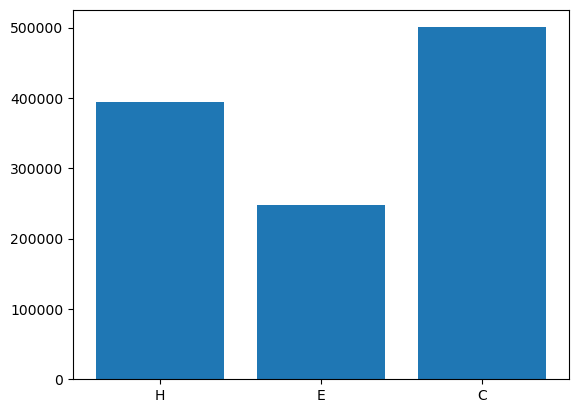

In [115]:
plt.bar(range(3), [num_0, num_1, num_2], tick_label=target_names)
plt.show()

### Load data in Pytorch Dataloaders

In [116]:
# Load train, test and validation data
train = Dataset("./Datasets/Datasets/train.pkl")
val = Dataset("./Datasets/Datasets/val.pkl")
test = Dataset("./Datasets/Datasets/test.pkl")

# Data Generators for each set.
train_gen = data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_batch)
val_gen = data.DataLoader(val, batch_size=BATCH_SIZE,shuffle=False,collate_fn=pad_batch)
test_gen = data.DataLoader(test, batch_size=BATCH_SIZE,shuffle=False,collate_fn=pad_batch)

In [117]:
train_iter = next(iter(train_gen))
print("Train Batch Shape: ", train_iter[0].shape, train_iter[1].shape, train_iter[2].shape, train_iter[3].shape, train_iter[4].shape)

Train Batch Shape:  torch.Size([557, 32]) torch.Size([557, 32, 22]) torch.Size([32]) torch.Size([557, 32]) torch.Size([557, 32])


## Defining different layers of our model

### Dense Layer

This is a simple NN fully connected layer with dropout and layernorm.

In [118]:
# Dense Layer
class Dense(nn.Module):
    def __init__(self,input_dim,output_dim,dropout = DROPOUT,normalization = True,activation = F.relu):
        super(Dense, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_rate = dropout
        self.activation = activation
        self.n_state = normalization        
        self.linear = nn.Linear(self.input_dim,self.output_dim)
        self.layernorm = nn.LayerNorm(self.output_dim)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        if self.n_state:
            x = self.layernorm(x)
        x = self.dropout(x)
        return x

A Unidirectional RNN Layer.

In [119]:
# Unidirectional RNN
class rnn_unidirectional(nn.Module):
    def __init__(self,inp,out,dropout=DROPOUT,activation=F.relu):
        super(rnn_unidirectional,self).__init__()
        self.rnn = nn.RNN(inp,out,bidirectional=False,num_layers=NUM_LAYERS)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False)
        out,_ = self.rnn(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

A Bidirectional RNN Layer

In [120]:
# Bidirectional RNN
class rnn_bidirectional(nn.Module):
    def __init__(self,inp,out,dropout=DROPOUT,activation=F.relu):
        super(rnn_bidirectional,self).__init__()
        self.rnn = nn.RNN(inp,out,bidirectional=True,num_layers=NUM_LAYERS)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(2*out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False)
        out,_ = self.rnn(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

A bidirectional GRU layer.

In [121]:
# Bidirectional GRU
class gru_bidirectional(nn.Module):
    def __init__(self,inp,out,dropout=0.1,activation=F.relu):
        super(gru_bidirectional,self).__init__()
        self.gru = nn.GRU(inp,out,bidirectional=True,num_layers=2)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(2*out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False) #as we padded our sequences while batching,this undos the padding
        out,_ = self.gru(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

## Defining model architectures

We define 3 different models, with a RNN(unidirectional), RNN(bidirectional) and GRU(Bidirectional) layer respectively,followed by a fully connected linear layer.

In each model,we have added an embedding layer to convert one hot embedding of atom to a higher dimensional embedding. Ths is is because pssm is in floats, and hence it would be better if atom type information was also provided to model in floating point representation, also this makes the representation less sparse and the model can learn relationships between different atom types

In [122]:
class RNN_unidir_model(nn.Module):
    def __init__(self,embedding_count=23,embedding_dim=50,output_dim=3):
        super(RNN_unidir_model, self).__init__()
        self.embedding = nn.Embedding(embedding_count,embedding_dim=embedding_dim,padding_idx=0)
        
        self.layernorm = nn.LayerNorm(22+embedding_dim)
        
        #RNN layer
        self.rnn_1 = rnn_unidirectional(22+embedding_dim,128,0.2)
        
        #Output layers
        self.linear_1 = Dense(128,64)
        self.Q3 = Dense(64,output_dim,dropout=0)
        
    def forward(self,x,pssm,x_lengths):
        emb = self.embedding(x) # Convert sequence of indices to embeddings
        emb = torch.cat([emb,pssm],dim=-1) # Concatenate PSSM features with embeddings

        x_normalized = self.layernorm(emb)
        
        gru = self.rnn_1(x_normalized,x_lengths)
        
        out = self.linear_1(gru)
        Q3 = self.Q3(out)
        return Q3

In [123]:
class RNN_bidirec_model(nn.Module):
    def __init__(self,embedding_count=23,embedding_dim=5050,output_dim=3):
        super(RNN_bidirec_model, self).__init__()
        self.embedding = nn.Embedding(embedding_count,embedding_dim=embedding_dim,padding_idx=0)
        
        self.layernorm = nn.LayerNorm(22+embedding_dim)
        
        #RNN bidirectional layer
        self.rnn_1 = rnn_bidirectional(22+embedding_dim,64,0.2)
        
        #Output layers
        self.linear_1 = Dense(128,64)
        self.Q3 = Dense(64,output_dim,dropout=0)
        
    def forward(self,x,pssm,x_lengths):
        emb = self.embedding(x) # Convert sequence of indices to embeddings
        emb = torch.cat([emb,pssm],dim=-1) # Concatenate PSSM features with embeddings

        x_normalized = self.layernorm(emb)
        
        gru = self.rnn_1(x_normalized,x_lengths)
        
        out = self.linear_1(gru)
        Q3 = self.Q3(out)
        return Q3

In [124]:
class GRU_bidirec_model(nn.Module):
    def __init__(self,embedding_count=23,embedding_dim=50,output_dim=3):
        super(GRU_bidirec_model, self).__init__()
        self.embedding = nn.Embedding(embedding_count,embedding_dim=embedding_dim,padding_idx=0)
        
        self.layernorm = nn.LayerNorm(22+embedding_dim)
        
        #GRU
        self.gru_1 = gru_bidirectional(22+embedding_dim,64,0.2)
        
        #Output layers
        self.linear_1 = Dense(128,64)
        self.Q3 = Dense(64,output_dim,dropout=0)
        
    def forward(self,x,pssm,x_lengths):
        emb = self.embedding(x)
        emb = torch.cat([emb,pssm],dim=-1)

        x_normalized = self.layernorm(emb)
        
        gru = self.gru_1(x_normalized,x_lengths)
        
        out = self.linear_1(gru)
        Q3 = self.Q3(out)
        return Q3

# Training Models

In [125]:
os.makedirs("saved_models", exist_ok=True) # Create directory to save models
results_dir = {} # Dictionary to store results of different models

### Train Epoch helper Function

In [126]:
def train_epoch(generator,network,optimizer,criterion,task="Q3"):
    #     Set the network in to train mode
    #     Enables dropout. 
    network.train()
    total_loss = 0.
    start_time = time.time() # Track training time.
    prediction = [] #output prediction of model - vector of probabilities for each class
    g_t = [] # ground truth labels for each sequence - actual secondary structure
    for seq,pssm,length,q8,q3 in tqdm.tqdm(generator,desc="Training"):
        batch_size = seq.shape[1]  # Get the batch size from the shape of the sequence tensor.
        optimizer.zero_grad()  # Make all gradients at each trainable parameter zero.
        output = network(seq.to(device),pssm.to(device),length.to(cpu)) # Perform a forward pass
        if task == "Q8":
            loss = criterion(output.view(-1,8).to(device),q8.view(-1).to(device))  #Compute the loss function
        else:
            loss = criterion(output.view(-1,3).to(device),q3.view(-1).to(device))
        loss.backward() # Perform back propagation 
        torch.nn.utils.clip_grad_norm_(network.parameters(), 0.5)  # Clip gradients to increase stability of training
        optimizer.step()  # Perform the optimization step.
        
        total_loss += loss.cpu().detach().numpy()
        
        # store all predictions to calculate accuracy at end of epoch
        for i in range(len(length)):
            prediction.append(output[0:length[i],i,:].cpu().detach().numpy())
            if task == "Q8":
                g_t.append(q8[0:length[i],i].cpu().detach().numpy())
            else:
                g_t.append(q3[0:length[i],i].cpu().detach().numpy())
    ave_loss = total_loss / len(generator)  # Average loss over the epoch
    predictions = np.argmax(np.concatenate(prediction,axis=0),axis=-1)
    g_ts = np.concatenate(g_t)
    
    # calculate accuracy
    acc = accuracy_score(predictions,g_ts) 
    end_time = time.time()
    return end_time-start_time , ave_loss, acc

### Evaluation Epoch Helper function

In [127]:
def evaluate(generator,network,criterion, print_acc_report=False,output_sample=False,task ="Q3"):
    
    with torch.no_grad(): # disable gradients as no optimization done during evaluation
        network.eval()  # set network to evaluation mode to disable dropouts
        total_loss = 0.
        start_time = time.time() # Track evaluation time
        prediction = []
        g_t = []   
        for seq,pssm,length,q8,q3 in tqdm.tqdm(generator,desc="Evaluating"):
            batch_size = seq.shape[1]  # Get the batch size from the shape of the sequence tensor.
            #    Get predictions
            output = network(seq.to(device),pssm.to(device),length.to(cpu))
            
            #    Calculate loss for analysis
            if task == "Q8":
                loss = criterion(output.view(-1,8).to(device),q8.view(-1).to(device))  #Compute the loss function
            else:
                loss = criterion(output.view(-1,3).to(device),q3.view(-1).to(device))        
            total_loss += loss.cpu().detach().numpy()
            for i in range(len(length)):
                prediction.append(output[0:length[i],i,:].cpu().detach().numpy())
                if task == "Q8":
                    g_t.append(q8[0:length[i],i].cpu().detach().numpy())
                else:
                    g_t.append(q3[0:length[i],i].cpu().detach().numpy())
        ave_loss = total_loss / len(generator)
        #   calculate  accuracy for analysis       
        predictions = np.argmax(np.concatenate(prediction,axis=0),axis=-1)
        g_ts = np.concatenate(g_t)
        acc = accuracy_score(predictions,g_ts) 
        end_time = time.time()
        if print_acc_report:
            print (classification_report(g_ts,predictions,target_names=target_names))
    return end_time-start_time, ave_loss, acc

### Train model function

In [128]:
def train_model(network,train_gen,val_gen,optimizer,criterion,num_epochs=100,
                patience=10, min_delta=0.001, save_best_model=True, model_save_path="best_model.pth",task="Q3"):
    """Train model for num_epochs epochs, with early stopping based on validation accuracy."""
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_epoch = 0
    for i in range(num_epochs):
        #     Train epoch
        run_time,train_loss,train_acc = train_epoch(train_gen,network,optimizer,criterion,task=task)
        
        #     Validation step
        _,val_loss,val_acc = evaluate(val_gen,network,criterion,task=task)
        
        #     Track performance of network during training
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # Early stopping logic based on validation accuracy
        if val_acc > best_val_acc + min_delta:
            # Significant improvement found
            best_val_acc = val_acc
            epochs_without_improvement = 0
            best_epoch = i + 1
            
            # Save the best model
            if save_best_model:
                torch.save(network.state_dict(), model_save_path)
                
        else:
            # No significant improvement
            epochs_without_improvement += 1
            
            if epochs_without_improvement >= patience:
                print(f"\n Early stopping triggered after {i + 1} epochs!")
                print(f"Best model was at epoch {best_epoch} with validation accuracy: {best_val_acc:.4f}")
                break
        
        #     Print performance metrics
        print ("Epoch : "+str(i)+", Train_loss : "+str(train_loss)+", Train_acc : "+str(train_acc)+", Val_acc : "+ str(val_acc))
    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

## Plotting Training Results

In [129]:
def plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history):
    """
    Plot training results showing loss and accuracy vs epoch.
    
    Args:
        train_acc_history: List of training accuracies per epoch
        val_acc_history: List of validation accuracies per epoch  
        train_loss_history: List of training losses per epoch
        val_loss_history: List of validation losses per epoch
    """
    epochs = range(1, len(train_acc_history) + 1)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracies
    axes[0].plot(epochs, train_acc_history, 'b-', label='Train Accuracy', marker='o', markersize=4)
    axes[0].plot(epochs, val_acc_history, 'r-', label='Validation Accuracy', marker='s', markersize=4)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Plot losses
    axes[1].plot(epochs, train_loss_history, 'b-', label='Train Loss', marker='o', markersize=4)
    axes[1].plot(epochs, val_loss_history, 'r-', label='Validation Loss', marker='s', markersize=4)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Evaluating Model

In [130]:
def evaluate_best_model(model_class, model_path, test_gen, criterion, device, task="Q3"):
    """
    Load the best model and evaluate it on test set with comprehensive metrics and plots.
    
    Args:
        model_class: The model class (e.g., RNN_unidir_model)
        model_path: Path to the saved best model weights
        test_gen: Test data generator
        criterion: Loss function
        device: Device to run evaluation on
        target_names: List of class names for confusion matrix
    """
    if task == "Q8":
        target_names = list(range(8))  # For Q8, target names are 0-7
    else:
        target_names = ["H", "E", "C"]
    
    # Load the best model
    if task == "Q8":
        model = model_class(output_dim=8).to(device)
    else:
        model = model_class(output_dim=3).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
  
    # Evaluate on test set
    with torch.no_grad():
        total_loss = 0.
        all_predictions = []
        all_targets = []
        
        for seq, pssm, length, q8, q3 in tqdm.tqdm(test_gen, desc="Evaluating on test set"):
            batch_size = seq.shape[1]
            
            # Get predictions
            output = model(seq.to(device), pssm.to(device), length.to('cpu'))
            
            # Calculate loss
            if task == "Q8":
                loss = criterion(output.view(-1, 8).to(device), q8.view(-1).to(device))
            else:
                loss = criterion(output.view(-1, 3).to(device), q3.view(-1).to(device))
            total_loss += loss.cpu().detach().numpy() / batch_size
            
            # Store predictions and targets for each sequence
            for i in range(len(length)):
                seq_predictions = output[0:length[i], i, :].cpu().detach().numpy()
                if task == "Q8":
                    seq_targets = q8[0:length[i], i].cpu().detach().numpy()
                else:
                    seq_targets = q3[0:length[i], i].cpu().detach().numpy()
                
                all_predictions.append(seq_predictions)
                all_targets.append(seq_targets)
        
        # Convert to flat arrays
        predictions_flat = np.argmax(np.concatenate(all_predictions, axis=0), axis=-1)
        targets_flat = np.concatenate(all_targets)
        
        # Calculate overall accuracy
        test_accuracy = accuracy_score(targets_flat, predictions_flat)
        avg_test_loss = total_loss / len(test_gen)
    
    # Print metrics
    print(f"\nTest Results:")
    print(f"  Test Loss:     {avg_test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # Create confusion matrix
    cm = confusion_matrix(targets_flat, predictions_flat)
    
    # Create plots
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names, ax=axes)
    axes.set_title('Confusion Matrix')
    axes.set_xlabel('Predicted')
    axes.set_ylabel('Actual')
 
    
    plt.tight_layout()
    plt.show()
    
    # Calculate per-class metrics
    print(f"\nPer-Class Performance:")
    for i, class_name in enumerate(target_names):
        # True positives, false positives, false negatives
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        
        # Precision, Recall, F1-score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"  {class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    
    return {
        'test_accuracy': test_accuracy,
        'test_loss': avg_test_loss,
        'confusion_matrix': cm,
        'predictions': predictions_flat,
        'targets': targets_flat,
        'classification_report': classification_report(targets_flat, predictions_flat, target_names=target_names, output_dict=True,zero_division=0)
    }

### Train RNN Unidirectional Model

In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
rnn_model = RNN_unidir_model().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(rnn_model.parameters(),lr=0.001)
train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    rnn_model, train_gen, val_gen, optimizer, criterion, num_epochs=EPOCHS,
    patience=PATIENCE, min_delta=MIN_DELTA, save_best_model=True, model_save_path="saved_models/best_rnn_model.pth"
)

cuda


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 18.72it/s]


Epoch : 0, Train_loss : 1.022226934222614, Train_acc : 0.47801925297881404, Val_acc : 0.5691221807561253


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.07it/s]


Epoch : 1, Train_loss : 0.9097861770321342, Train_acc : 0.6047855551836359, Val_acc : 0.6153050462437125


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 11.51it/s]


Epoch : 2, Train_loss : 0.8923599386916441, Train_acc : 0.613025816096023, Val_acc : 0.6534763913678403


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s]


Epoch : 3, Train_loss : 0.8616825317635256, Train_acc : 0.642550204779772, Val_acc : 0.6595610903780627


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 20.13it/s]


Epoch : 4, Train_loss : 0.8529476488337797, Train_acc : 0.6405952896271203, Val_acc : 0.6619746876521174


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 14.56it/s]


Epoch : 5, Train_loss : 0.8473464180441463, Train_acc : 0.6358889475003199, Val_acc : 0.649825571961707


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 18.91it/s]


Epoch : 6, Train_loss : 0.8345105090562035, Train_acc : 0.6551682138331935, Val_acc : 0.6728865812104494


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.93it/s]


Epoch : 7, Train_loss : 0.8235293444465188, Train_acc : 0.6586127550546518, Val_acc : 0.6753204608145383


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.26it/s]


Epoch : 8, Train_loss : 0.8327514410018921, Train_acc : 0.645358588044787, Val_acc : 0.6530707447671589


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.08it/s]


Epoch : 9, Train_loss : 0.8180158040102791, Train_acc : 0.6592760767805851, Val_acc : 0.6874087295148467


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.68it/s]


Epoch : 10, Train_loss : 0.811470426531399, Train_acc : 0.6627950993054837, Val_acc : 0.6424225214992698


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 14.22it/s]


Epoch : 11, Train_loss : 0.8126121082726647, Train_acc : 0.6591367529306202, Val_acc : 0.6900859970793445


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 13.62it/s]


Epoch : 12, Train_loss : 0.8009894090540269, Train_acc : 0.6738130747108811, Val_acc : 0.6789104332305695


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


Epoch : 13, Train_loss : 0.7997996761518367, Train_acc : 0.6661555204665859, Val_acc : 0.6868611066039266


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.58it/s]


Epoch : 14, Train_loss : 0.7929658837178174, Train_acc : 0.668492480893355, Val_acc : 0.6915666071718319


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 14.50it/s]


Epoch : 15, Train_loss : 0.7942132153931786, Train_acc : 0.6728614665281022, Val_acc : 0.694872626967386


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.15it/s]


Epoch : 16, Train_loss : 0.7905874673058005, Train_acc : 0.6715146693117753, Val_acc : 0.6809386662339769


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 17.54it/s]


Epoch : 17, Train_loss : 0.7897855618420769, Train_acc : 0.6679921417843617, Val_acc : 0.662927957163719


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.12it/s]


Epoch : 18, Train_loss : 0.781490558385849, Train_acc : 0.6818351492167196, Val_acc : 0.7018903131591757


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.20it/s]


Epoch : 19, Train_loss : 0.7715302018558278, Train_acc : 0.688090702455079, Val_acc : 0.6975498945318839


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.64it/s]


Epoch : 20, Train_loss : 0.7676588395062615, Train_acc : 0.689660943581727, Val_acc : 0.6832305695278273


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s]


Epoch : 21, Train_loss : 0.7705234303193934, Train_acc : 0.6877866434869166, Val_acc : 0.6781599870193088


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.85it/s]


Epoch : 22, Train_loss : 0.7677676498889923, Train_acc : 0.6871136830040676, Val_acc : 0.7053585915950025


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 13.27it/s]


Epoch : 23, Train_loss : 0.7643310750232023, Train_acc : 0.6893165770846441, Val_acc : 0.6875709881551193


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 21.14it/s]


Epoch : 24, Train_loss : 0.7624484020120957, Train_acc : 0.6920907865751393, Val_acc : 0.7022756774298231


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 21.37it/s]


Epoch : 25, Train_loss : 0.7606554690529318, Train_acc : 0.6933201662072193, Val_acc : 0.7029855589810158


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.60it/s]


Epoch : 26, Train_loss : 0.7516724842436173, Train_acc : 0.6973579291043142, Val_acc : 0.7026001947103683


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.59it/s]


Epoch : 27, Train_loss : 0.7569164093802957, Train_acc : 0.6895934722833164, Val_acc : 0.693513710855103


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 20.24it/s]


Epoch : 28, Train_loss : 0.7449516205226674, Train_acc : 0.6997632370801226, Val_acc : 0.7100438098328736


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 17.09it/s]


Epoch : 29, Train_loss : 0.7466897841762093, Train_acc : 0.7000716773014285, Val_acc : 0.7043241927632646


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.68it/s]


Epoch : 30, Train_loss : 0.742536052535562, Train_acc : 0.7029799531381163, Val_acc : 0.7037765698523446


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.05it/s]


Epoch : 31, Train_loss : 0.737444647620706, Train_acc : 0.7046947756185015, Val_acc : 0.718602953107253


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.94it/s]


Epoch : 32, Train_loss : 0.7324011739562539, Train_acc : 0.7069835422606916, Val_acc : 0.7156620152523122


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 21.19it/s]


Epoch : 33, Train_loss : 0.7388083605205311, Train_acc : 0.7034049346930407, Val_acc : 0.7089688463410677


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 20.11it/s]


Epoch : 34, Train_loss : 0.7333044227431802, Train_acc : 0.70772485029258, Val_acc : 0.7180147655362648


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 24.65it/s]


Epoch : 35, Train_loss : 0.736060064680436, Train_acc : 0.705016359599238, Val_acc : 0.7167978257342204


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.66it/s]


Epoch : 36, Train_loss : 0.7333194743184482, Train_acc : 0.7057541626286117, Val_acc : 0.71943452863865


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 14.55it/s]


Epoch : 37, Train_loss : 0.7287584553746617, Train_acc : 0.7080052504937673, Val_acc : 0.7182581534966737


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 17.51it/s]


Epoch : 38, Train_loss : 0.7249069978209103, Train_acc : 0.7108127575081535, Val_acc : 0.7236735356157715


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.44it/s]


Epoch : 39, Train_loss : 0.725071049788419, Train_acc : 0.7095080203220046, Val_acc : 0.7138974525393477


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 20.17it/s]


Epoch : 40, Train_loss : 0.7200933172422297, Train_acc : 0.7119571408292485, Val_acc : 0.7233287360051923


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s]


Epoch : 41, Train_loss : 0.7166634121361901, Train_acc : 0.7130147753381013, Val_acc : 0.719170858348207


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 18.74it/s]


Epoch : 42, Train_loss : 0.7055080434855293, Train_acc : 0.7168746593575681, Val_acc : 0.7243022878468278


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


Epoch : 43, Train_loss : 0.6983893916887396, Train_acc : 0.7183791816870628, Val_acc : 0.7255192276488723


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 48.19it/s]


Epoch : 44, Train_loss : 0.6930935442447662, Train_acc : 0.7207564496427527, Val_acc : 0.7301435988966413


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 55.59it/s]


Epoch : 45, Train_loss : 0.6969609565594617, Train_acc : 0.7191905897692482, Val_acc : 0.7279328249229271


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 56.74it/s]


Epoch : 46, Train_loss : 0.6936944070984336, Train_acc : 0.7187375681942052, Val_acc : 0.7269187084212234


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 55.04it/s]


Epoch : 47, Train_loss : 0.6880868392832139, Train_acc : 0.7211043211423505, Val_acc : 0.7282776245335064


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 62.76it/s]


Epoch : 48, Train_loss : 0.6935840806540321, Train_acc : 0.7171480495537256, Val_acc : 0.7278314132727568


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 59.50it/s]


Epoch : 49, Train_loss : 0.6866274311262018, Train_acc : 0.7201264254407103, Val_acc : 0.7309751744280383


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 58.27it/s]


Epoch : 50, Train_loss : 0.6779450244763319, Train_acc : 0.7257940145072054, Val_acc : 0.7336524419925361


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 60.05it/s]


Epoch : 51, Train_loss : 0.6773510343888227, Train_acc : 0.7251710003101928, Val_acc : 0.7268984260911894


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 60.31it/s]


Epoch : 52, Train_loss : 0.6790930442950305, Train_acc : 0.7236244179505199, Val_acc : 0.7337335713126724


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 55.22it/s]


Epoch : 53, Train_loss : 0.6763474874636706, Train_acc : 0.7242185158767851, Val_acc : 0.7312996917085834


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 60.93it/s]


Epoch : 54, Train_loss : 0.6774801583851084, Train_acc : 0.7249344126404411, Val_acc : 0.7264319325004056


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 60.95it/s]


Epoch : 55, Train_loss : 0.6771582147654365, Train_acc : 0.721413637614285, Val_acc : 0.7264724971604738


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 58.17it/s]


Epoch : 56, Train_loss : 0.677329899633632, Train_acc : 0.7239451256806276, Val_acc : 0.7342811942235924


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 53.96it/s]


Epoch : 57, Train_loss : 0.6708164467531093, Train_acc : 0.7276595520957286, Val_acc : 0.732516631510628


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 65.14it/s]


Epoch : 58, Train_loss : 0.6781488632454592, Train_acc : 0.7185737093266364, Val_acc : 0.7319487262696739


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 34.72it/s]


Epoch : 59, Train_loss : 0.6692526743692511, Train_acc : 0.7270952466908395, Val_acc : 0.732557196170696


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 58.29it/s]


 Early stopping triggered after 61 epochs!
Best model was at epoch 51 with validation accuracy: 0.7337


### Plotting training results and evaluating RNN unidirectional model

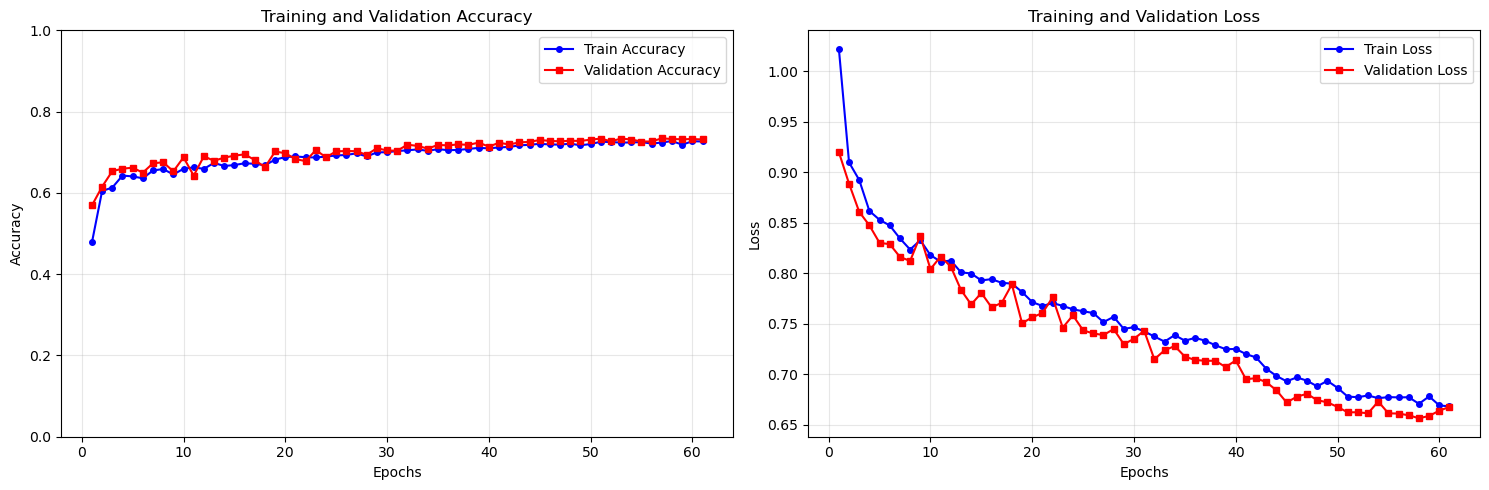

Evaluating on test set: 100%|██████████| 9/9 [00:00<00:00, 27.80it/s]



Test Results:
  Test Loss:     0.0343
  Test Accuracy: 0.7264 (72.64%)


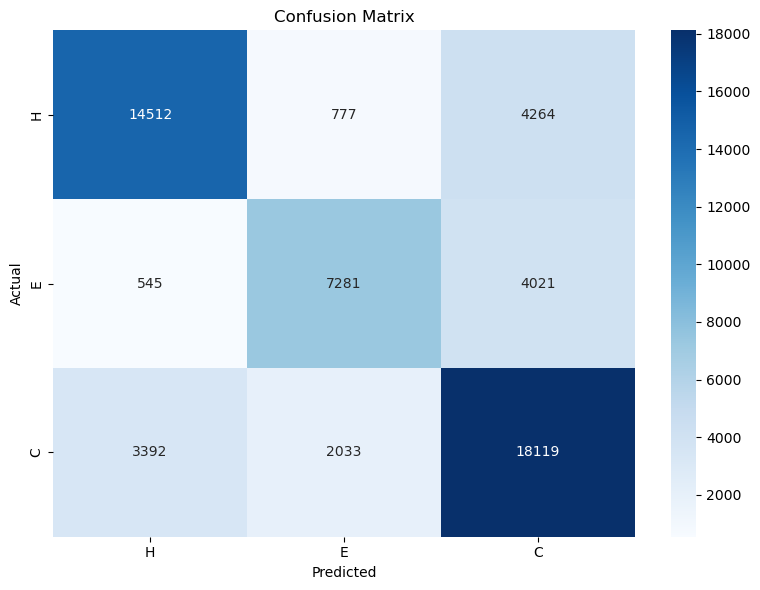


Per-Class Performance:
  H: Precision=0.787, Recall=0.742, F1=0.764
  E: Precision=0.722, Recall=0.615, F1=0.664
  C: Precision=0.686, Recall=0.770, F1=0.726


In [133]:
# Plot training results
plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history)
# Evaluate the best model
results = evaluate_best_model(
    model_class=RNN_unidir_model,
    model_path="saved_models/best_rnn_model.pth", 
    test_gen=test_gen,
    criterion=criterion,
    device=device,
    task = "Q3"
)
results_dir["RNN_unidir"] = results

## RNN_Bidirectional Model

Training the model

In [134]:
rnn_bi_model = RNN_bidirec_model().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(rnn_bi_model.parameters(),lr=0.001)
train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    rnn_bi_model, train_gen, val_gen, optimizer, criterion, num_epochs=EPOCHS,
    patience=PATIENCE, min_delta=MIN_DELTA, save_best_model=True, model_save_path="saved_models/best_rnn_bi_model.pth"
)

Training:   0%|          | 0/170 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.48it/s]


Epoch : 0, Train_loss : 1.11212359456455, Train_acc : 0.4627830070468076, Val_acc : 0.46852182378711665


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 21.15it/s]


Epoch : 1, Train_loss : 1.0576368780697094, Train_acc : 0.4689868614980731, Val_acc : 0.4743022878468278


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 20.26it/s]


Epoch : 2, Train_loss : 1.0372228843324325, Train_acc : 0.47219744380166595, Val_acc : 0.4732070420249878


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 17.27it/s]


Epoch : 3, Train_loss : 1.0271223762456108, Train_acc : 0.4715998408728858, Val_acc : 0.4732070420249878


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.54it/s]


Epoch : 4, Train_loss : 1.0229216470437892, Train_acc : 0.48278605639899547, Val_acc : 0.4860254746065228


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 20.31it/s]


Epoch : 5, Train_loss : 1.0207283602041357, Train_acc : 0.4847067977771274, Val_acc : 0.4850722050949213


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 18.86it/s]


Epoch : 6, Train_loss : 1.019706489759333, Train_acc : 0.48424676619705476, Val_acc : 0.483895829952945


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 21.44it/s]


Epoch : 7, Train_loss : 1.0191590936744914, Train_acc : 0.48273348136127286, Val_acc : 0.4816647736491968


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.78it/s]


Epoch : 8, Train_loss : 1.0186761242501876, Train_acc : 0.4831996466957465, Val_acc : 0.4812794093785494


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]


Epoch : 9, Train_loss : 1.0179780195741093, Train_acc : 0.4834195856035527, Val_acc : 0.4816647736491968


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 20.51it/s]


Epoch : 10, Train_loss : 1.017613825377296, Train_acc : 0.4832171717083207, Val_acc : 0.48077235112769756


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 18.55it/s]


Epoch : 11, Train_loss : 1.017341487197315, Train_acc : 0.48079696747182415, Val_acc : 0.47815593055330197


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s]


Epoch : 12, Train_loss : 1.0168089712367339, Train_acc : 0.48153126549868297, Val_acc : 0.4816647736491968


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 21.09it/s]


Epoch : 13, Train_loss : 1.016743226962931, Train_acc : 0.48351509692208205, Val_acc : 0.4816647736491968


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 20.21it/s]


 Early stopping triggered after 15 epochs!
Best model was at epoch 5 with validation accuracy: 0.4860


Plotting graph and evaluating results

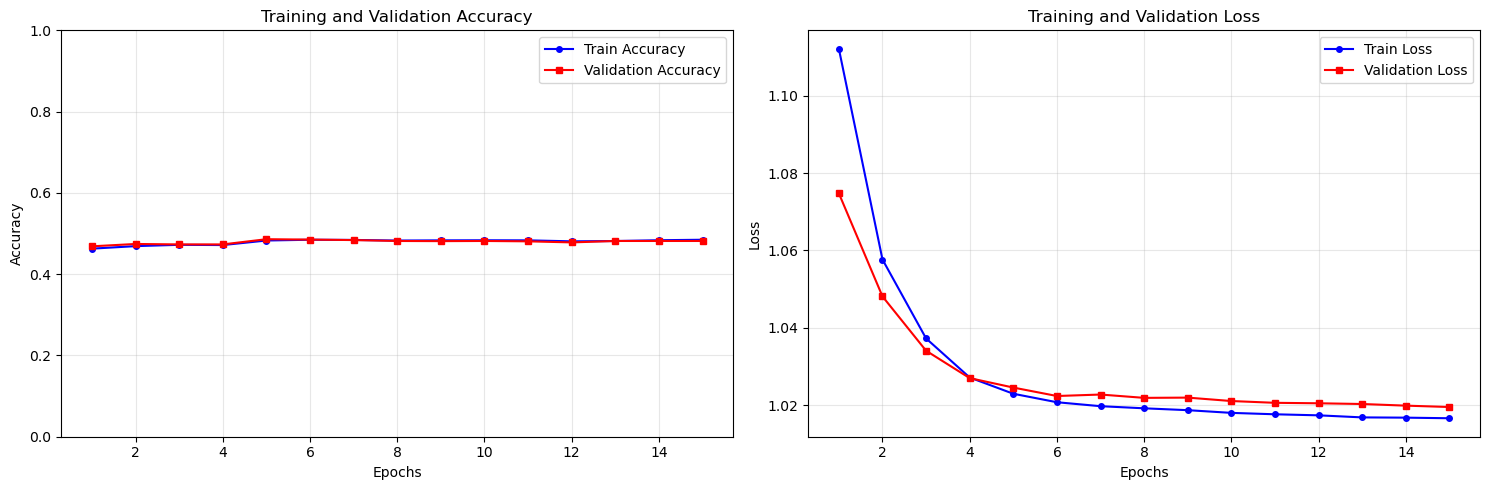

Evaluating on test set: 100%|██████████| 9/9 [00:00<00:00, 16.29it/s]



Test Results:
  Test Loss:     0.0563
  Test Accuracy: 0.4917 (49.17%)


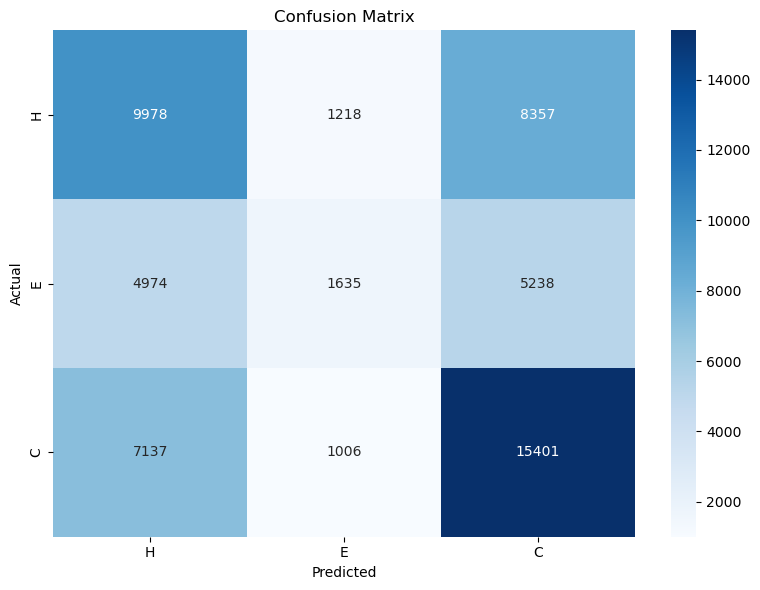


Per-Class Performance:
  H: Precision=0.452, Recall=0.510, F1=0.479
  E: Precision=0.424, Recall=0.138, F1=0.208
  C: Precision=0.531, Recall=0.654, F1=0.586


In [135]:
# Plot training results
plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history)
# Evaluate the best model
results = evaluate_best_model(
    model_class=RNN_bidirec_model,
    model_path="saved_models/best_rnn_bi_model.pth", 
    test_gen=test_gen,
    criterion=criterion,
    device=device,
    task = "Q3"
)
results_dir["RNN_bidirec"] = results

## GRU Bidirectional Model

Training the model

In [136]:
gru_model = GRU_bidirec_model().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(gru_model.parameters(),lr=0.001)
train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    gru_model, train_gen, val_gen, optimizer, criterion, num_epochs=EPOCHS,
    patience=PATIENCE, min_delta=MIN_DELTA, save_best_model=True, model_save_path="saved_models/best_gru_model.pth"
)

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 22.83it/s]


Epoch : 0, Train_loss : 1.0066101365229663, Train_acc : 0.5178649978181359, Val_acc : 0.549671426253448


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 23.74it/s]


Epoch : 1, Train_loss : 0.9495254481540006, Train_acc : 0.5811618382336189, Val_acc : 0.5414368002596138


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.60it/s]


Epoch : 2, Train_loss : 0.9421722724157221, Train_acc : 0.5792586218680612, Val_acc : 0.6178606198280059


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 24.62it/s]


Epoch : 3, Train_loss : 0.932288539760253, Train_acc : 0.5792822806350364, Val_acc : 0.5839688463410677


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.81it/s]


Epoch : 4, Train_loss : 0.9281807166688583, Train_acc : 0.5854186637878913, Val_acc : 0.5667085834820704


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.13it/s]


Epoch : 5, Train_loss : 0.9128936374888701, Train_acc : 0.6075159521426957, Val_acc : 0.6184893720590622


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 24.58it/s]


Epoch : 6, Train_loss : 0.9072691871839411, Train_acc : 0.6072267894352215, Val_acc : 0.6293201362972578


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 24.99it/s]


Epoch : 7, Train_loss : 0.8250986870597391, Train_acc : 0.6348628580141006, Val_acc : 0.6351208826870031


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.44it/s]


Epoch : 8, Train_loss : 0.6561743150739109, Train_acc : 0.7390341615070108, Val_acc : 0.7791254259289307


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.09it/s]


Epoch : 9, Train_loss : 0.5750779721666784, Train_acc : 0.781056512908048, Val_acc : 0.7966087944183028


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.19it/s]


Epoch : 10, Train_loss : 0.5417470192208009, Train_acc : 0.7933879880058814, Val_acc : 0.8053301963329548


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 23.95it/s]


Epoch : 11, Train_loss : 0.5132095226470161, Train_acc : 0.8039836106082406, Val_acc : 0.813037481745903


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.40it/s]


Epoch : 12, Train_loss : 0.48669704724760615, Train_acc : 0.813168469698377, Val_acc : 0.815775596300503


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.60it/s]


Epoch : 13, Train_loss : 0.46694710202076856, Train_acc : 0.8198051919602253, Val_acc : 0.8257545026772676


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 29.07it/s]


Epoch : 14, Train_loss : 0.4513872181668001, Train_acc : 0.8249391443938361, Val_acc : 0.8266469251987668


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.86it/s]


Epoch : 15, Train_loss : 0.43961120878948884, Train_acc : 0.8294036413471126, Val_acc : 0.8337660230407269


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.03it/s]


Epoch : 16, Train_loss : 0.429866588992231, Train_acc : 0.832962971400932, Val_acc : 0.834861268862567


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 23.77it/s]


Epoch : 17, Train_loss : 0.4222193742499632, Train_acc : 0.8358353209618428, Val_acc : 0.8353277624533506


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.89it/s]


Epoch : 18, Train_loss : 0.41557325738317824, Train_acc : 0.8383343877549232, Val_acc : 0.83841067661853


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.75it/s]


Epoch : 19, Train_loss : 0.4123632844756631, Train_acc : 0.8394901623341915, Val_acc : 0.8424874249553789


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 30.12it/s]


Epoch : 20, Train_loss : 0.40805122378994435, Train_acc : 0.8410884434809582, Val_acc : 0.8412299204932663


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.32it/s]


Epoch : 21, Train_loss : 0.40177461084197547, Train_acc : 0.8428654797559817, Val_acc : 0.8417978257342204


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 24.91it/s]


Epoch : 22, Train_loss : 0.3962725216851515, Train_acc : 0.8453803190603789, Val_acc : 0.8423657309751744


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]


Epoch : 23, Train_loss : 0.39245249436182134, Train_acc : 0.8464589835843207, Val_acc : 0.8459354210611715


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 22.42it/s]


Epoch : 24, Train_loss : 0.38926021456718446, Train_acc : 0.8476909919682868, Val_acc : 0.8443128346584455


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.06it/s]


Epoch : 25, Train_loss : 0.38436108214013714, Train_acc : 0.8493558681628354, Val_acc : 0.8447387635891611


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 24.60it/s]


Epoch : 26, Train_loss : 0.3813708329901976, Train_acc : 0.8501155774579269, Val_acc : 0.8480245010546812


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.20it/s]


Epoch : 27, Train_loss : 0.37704546363914715, Train_acc : 0.8517375173716687, Val_acc : 0.8481867596949537


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]


Epoch : 28, Train_loss : 0.3736677453798406, Train_acc : 0.8535636236819, Val_acc : 0.8483490183352264


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]


Epoch : 29, Train_loss : 0.3694636809475282, Train_acc : 0.854801765820267, Val_acc : 0.8502352750283952


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]


Epoch : 30, Train_loss : 0.3658007521839703, Train_acc : 0.8561073792570446, Val_acc : 0.8480245010546812


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 14.59it/s]


Epoch : 31, Train_loss : 0.3625415616175708, Train_acc : 0.8571588800114964, Val_acc : 0.8492008761966575


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]


Epoch : 32, Train_loss : 0.3601225321783739, Train_acc : 0.8584206809168385, Val_acc : 0.8506409216290768


Training:   6%|▋         | 11/170 [01:32<22:23,  8.45s/it]  


KeyboardInterrupt: 

Plotting and Evaluating results

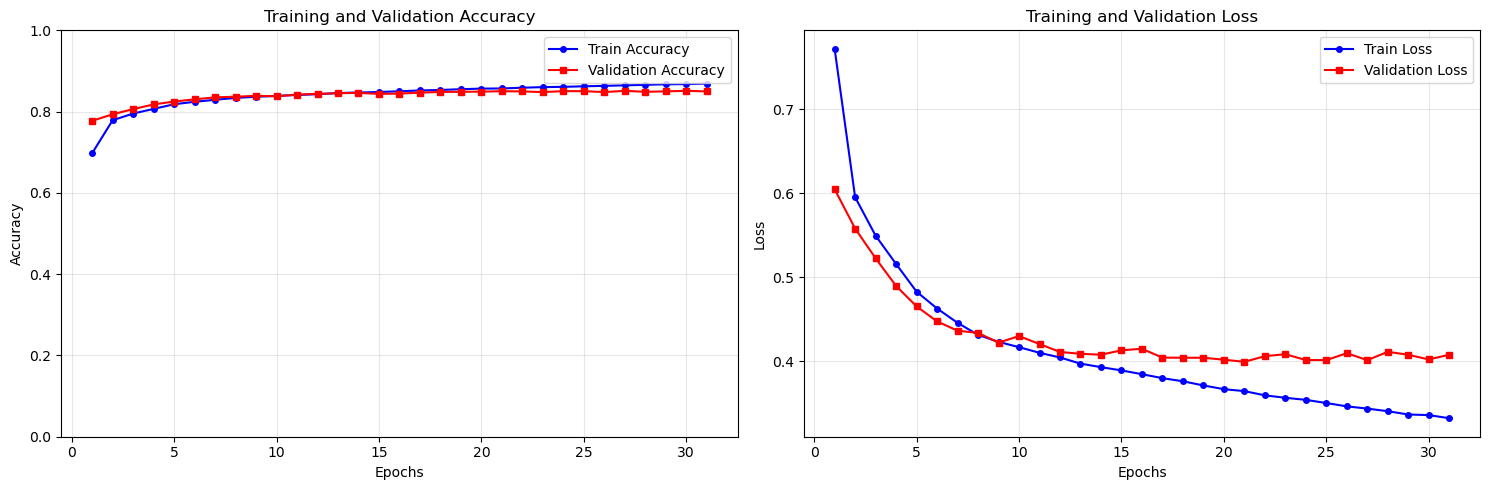

Evaluating on test set: 100%|██████████| 9/9 [00:00<00:00, 24.05it/s]



Test Results:
  Test Loss:     0.0197
  Test Accuracy: 0.8434 (84.34%)

Detailed Classification Report:
              precision    recall  f1-score   support

           H       0.89      0.90      0.89     19553
           E       0.82      0.76      0.79     11847
           C       0.82      0.84      0.83     23544

    accuracy                           0.84     54944
   macro avg       0.84      0.83      0.84     54944
weighted avg       0.84      0.84      0.84     54944



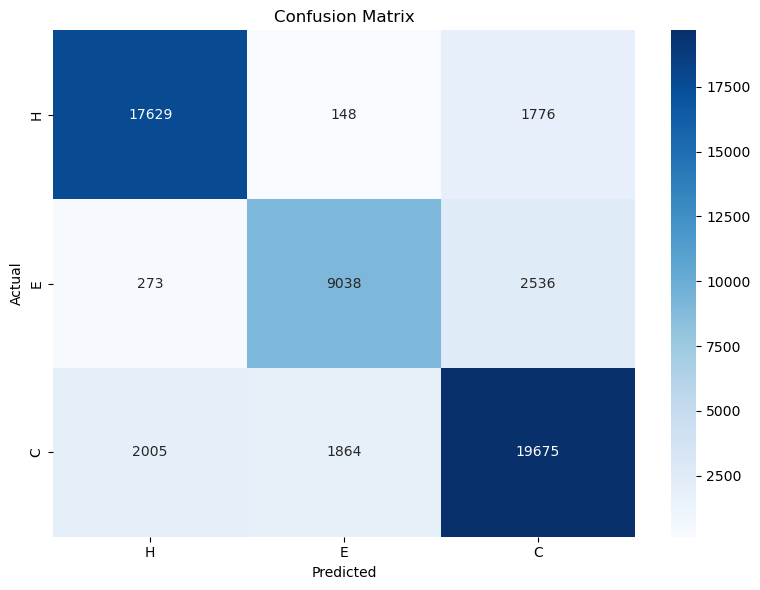


Per-Class Performance:
  H: Precision=0.886, Recall=0.902, F1=0.894
  E: Precision=0.818, Recall=0.763, F1=0.789
  C: Precision=0.820, Recall=0.836, F1=0.828
Classification_report : 
              precision    recall  f1-score   support

           H       0.89      0.90      0.89     19553
           E       0.82      0.76      0.79     11847
           C       0.82      0.84      0.83     23544

    accuracy                           0.84     54944
   macro avg       0.84      0.83      0.84     54944
weighted avg       0.84      0.84      0.84     54944



In [ ]:
# Plot training results
plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history)
# Evaluate the best model
results = evaluate_best_model(
    model_class=GRU_bidirec_model,
    model_path="saved_models/best_gru_model.pth", 
    test_gen=test_gen,
    criterion=criterion,
    device=device,
    task = "Q3"
)
results_dir["GRU_bidirec"] = results

## Comparing Results

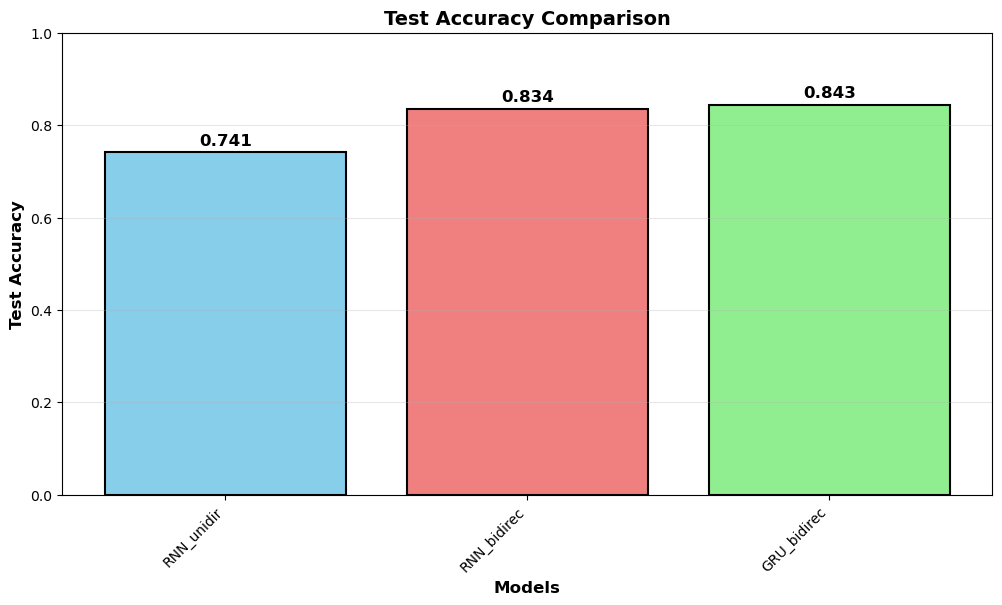

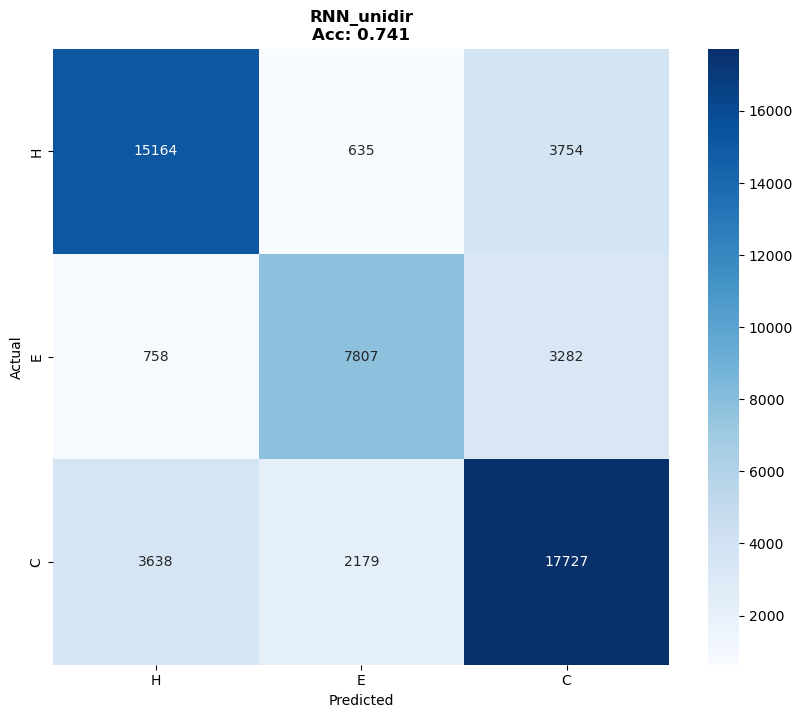

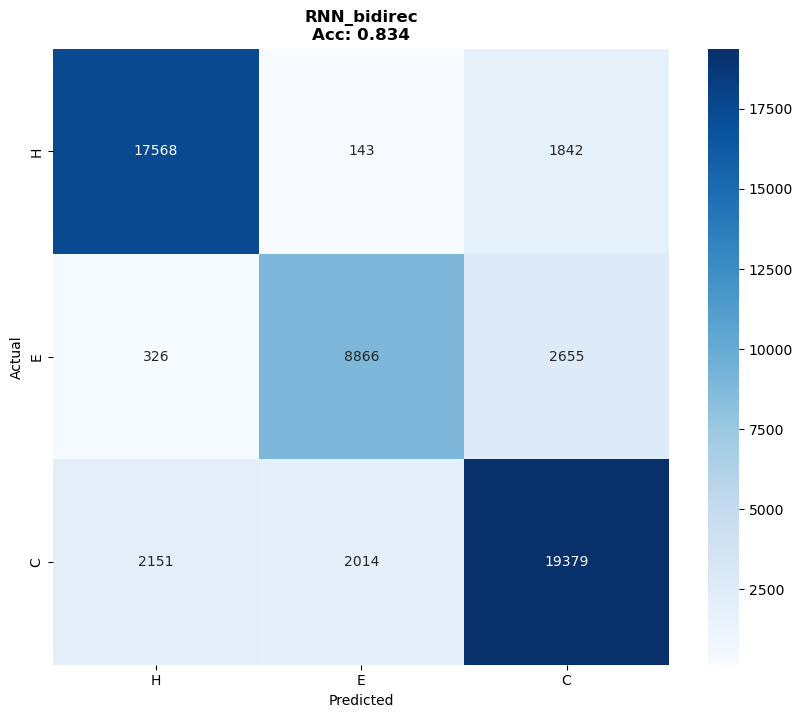

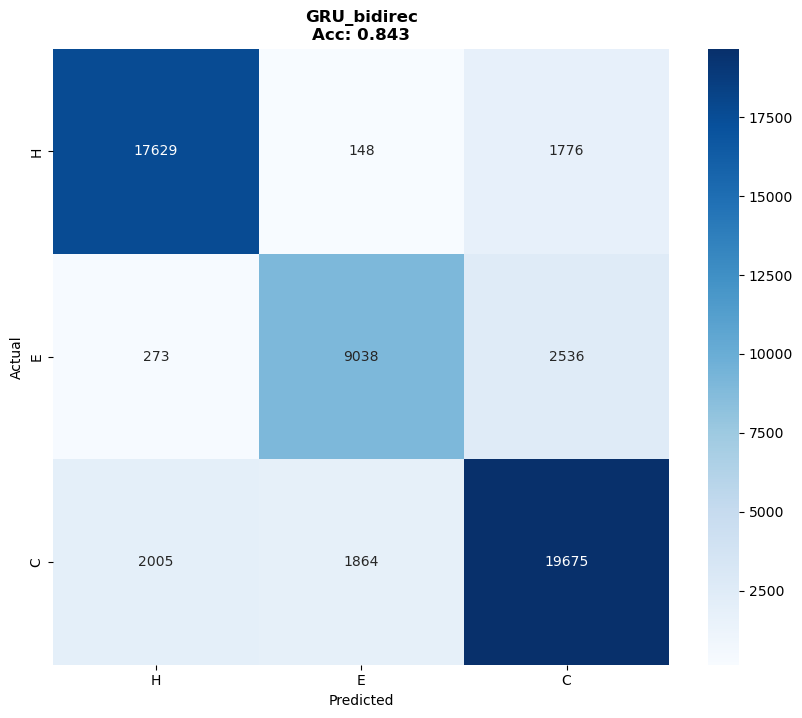

In [ ]:
model_names = list(results_dir.keys())
num_models = len(model_names)

# Extract test accuracies
test_accuracies = [results_dir[model]['test_accuracy'] for model in model_names]

# Create figure with subplots


# 1. Test Accuracy Comparison Bar Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(num_models), test_accuracies, 
                color=['skyblue', 'lightcoral', 'lightgreen'][:num_models],
                edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, test_accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=12, fontweight='bold')
plt.title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xticks(range(num_models), model_names, rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 2. Confusion Matrices for each model
for i, model_name in enumerate(model_names):
    cm = results_dir[model_name]['confusion_matrix']
    test_acc = results_dir[model_name]['test_accuracy']
    
    # Raw confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                cbar=True, square=True)
    plt.title(f'{model_name}\nAcc: {test_acc:.3f}', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Actual', fontsize=10)
    plt.show()


# Q8 Task

From our previous results, we can see that the bidirectional GRU had the best performance.

However,in previous section we just used q3 labels('H','E','C'),however dataset also contains q8 labels.(8 different types of secondary structure).

Lets see how well our model performs on Q8 secondary structure prediction task.

First, lets see distribution of labels in Q8 task .

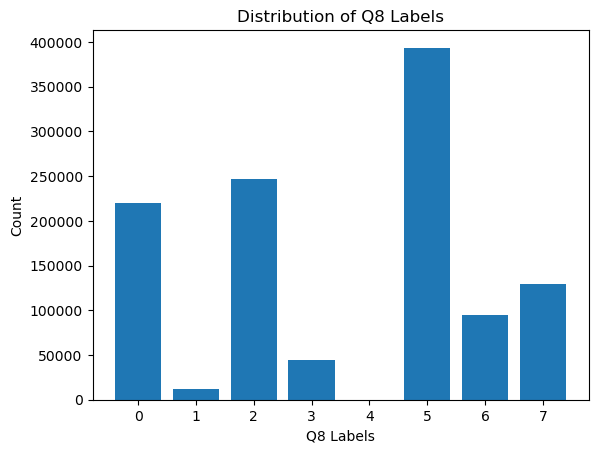

In [ ]:
q8_label_count =[0] * 8
for i in var:
    for j in var[i]["secstr"]:
        if j < 8:
            q8_label_count[j] += 1
plt.bar(range(8), q8_label_count, tick_label=range(8))
plt.xlabel('Q8 Labels')
plt.ylabel('Count')
plt.title('Distribution of Q8 Labels')
plt.show()

We have very little data on 1,4,6,7 so model will probably struggle with those labels. Lets see if our hypothesis is true.

### Training the model

In [ ]:
gru_model = GRU_bidirec_model(output_dim=8).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(gru_model.parameters(),lr=0.001)
train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    gru_model, train_gen, val_gen, optimizer, criterion, num_epochs=EPOCHS,
    patience=PATIENCE, min_delta=MIN_DELTA, save_best_model=True, model_save_path="saved_models/best_gru_model_q8.pth",task="Q8"
)

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.12it/s]


Epoch : 0, Train_loss : 1.2760368157835569, Train_acc : 0.5538254473697585, Val_acc : 0.634005354535129


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.09it/s]


Epoch : 1, Train_loss : 1.060623485551161, Train_acc : 0.6330341229519832, Val_acc : 0.6548758721401915


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.27it/s]


Epoch : 2, Train_loss : 0.979671466701171, Train_acc : 0.6564808372750007, Val_acc : 0.6686070095732598


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.95it/s]


Epoch : 3, Train_loss : 0.9279049249256358, Train_acc : 0.6713324091810036, Val_acc : 0.6811212072042836


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 29.31it/s]


Epoch : 4, Train_loss : 0.8890778481960296, Train_acc : 0.682323220816911, Val_acc : 0.6889907512575044


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.00it/s]


Epoch : 5, Train_loss : 0.8654686412390541, Train_acc : 0.6891229256956992, Val_acc : 0.694608956676943


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.76it/s]


Epoch : 6, Train_loss : 0.849328296324786, Train_acc : 0.6942376006154785, Val_acc : 0.6985437287035534


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.21it/s]


Epoch : 7, Train_loss : 0.8361526170197655, Train_acc : 0.6982744872619446, Val_acc : 0.7022959597598573


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.81it/s]


Epoch : 8, Train_loss : 0.8253851936143988, Train_acc : 0.701719028483403, Val_acc : 0.6994564335550868


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.14it/s]


Epoch : 9, Train_loss : 0.8153372224639444, Train_acc : 0.7050601721306735, Val_acc : 0.707691059548921


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.47it/s]


Epoch : 10, Train_loss : 0.8071926365880405, Train_acc : 0.7077318602976098, Val_acc : 0.7091311049813402


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.22it/s]


Epoch : 11, Train_loss : 0.7989812048042522, Train_acc : 0.7103544784293383, Val_acc : 0.7110376440045433


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.33it/s]


Epoch : 12, Train_loss : 0.7918077837018406, Train_acc : 0.7124127911561776, Val_acc : 0.7128022067175077


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.32it/s]


Epoch : 13, Train_loss : 0.7852638395393596, Train_acc : 0.7148329953926742, Val_acc : 0.7141002758396885


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.29it/s]


Epoch : 14, Train_loss : 0.7797456958714654, Train_acc : 0.7165925066551235, Val_acc : 0.7144247931202337


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


Epoch : 15, Train_loss : 0.7742808503263137, Train_acc : 0.7184142317122113, Val_acc : 0.7128224890475418


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.83it/s]


Epoch : 16, Train_loss : 0.7698705080677481, Train_acc : 0.7203121905739968, Val_acc : 0.714810157390881


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.27it/s]


Epoch : 17, Train_loss : 0.7650006785112269, Train_acc : 0.7215310551985321, Val_acc : 0.7161893558331981


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.50it/s]


Epoch : 18, Train_loss : 0.7601605874650619, Train_acc : 0.723322111483615, Val_acc : 0.7171629076748337


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.22it/s]


Epoch : 19, Train_loss : 0.7556388244909399, Train_acc : 0.724662774945541, Val_acc : 0.7187043647574234


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.17it/s]


Epoch : 20, Train_loss : 0.7515072173932019, Train_acc : 0.7263127548794016, Val_acc : 0.7174062956352426


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 30.36it/s]


Epoch : 21, Train_loss : 0.7478662343586192, Train_acc : 0.7271819955030818, Val_acc : 0.7159459678727892


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.00it/s]


Epoch : 22, Train_loss : 0.7425321736756493, Train_acc : 0.7289143429960411, Val_acc : 0.7161285088430959


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.63it/s]


Epoch : 23, Train_loss : 0.7396789561299717, Train_acc : 0.7303435077714668, Val_acc : 0.719170858348207


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.37it/s]


Epoch : 24, Train_loss : 0.7356073067468756, Train_acc : 0.7317709200456352, Val_acc : 0.7179742008761967


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.16it/s]


Epoch : 25, Train_loss : 0.7318252703722785, Train_acc : 0.7328452033164333, Val_acc : 0.7168383903942885


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.75it/s]


Epoch : 26, Train_loss : 0.7282827720922582, Train_acc : 0.7338861890633407, Val_acc : 0.718075612526367


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.17it/s]


Epoch : 27, Train_loss : 0.7252011008122388, Train_acc : 0.7346134770851698, Val_acc : 0.7165950024338796


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.85it/s]


Epoch : 28, Train_loss : 0.7221328304094426, Train_acc : 0.7361162469134072, Val_acc : 0.7165950024338796


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.60it/s]



 Early stopping triggered after 30 epochs!
Best model was at epoch 20 with validation accuracy: 0.7187


## Plotting and evaluating model

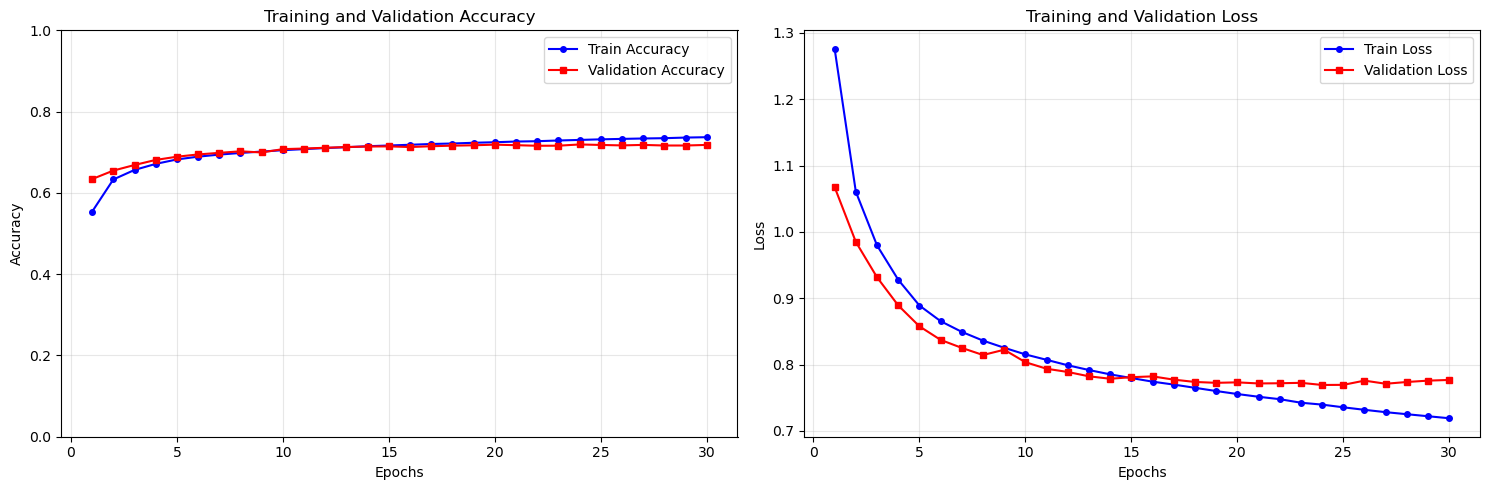

Evaluating on test set: 100%|██████████| 9/9 [00:00<00:00, 17.13it/s]



Test Results:
  Test Loss:     0.0388
  Test Accuracy: 0.7167 (71.67%)


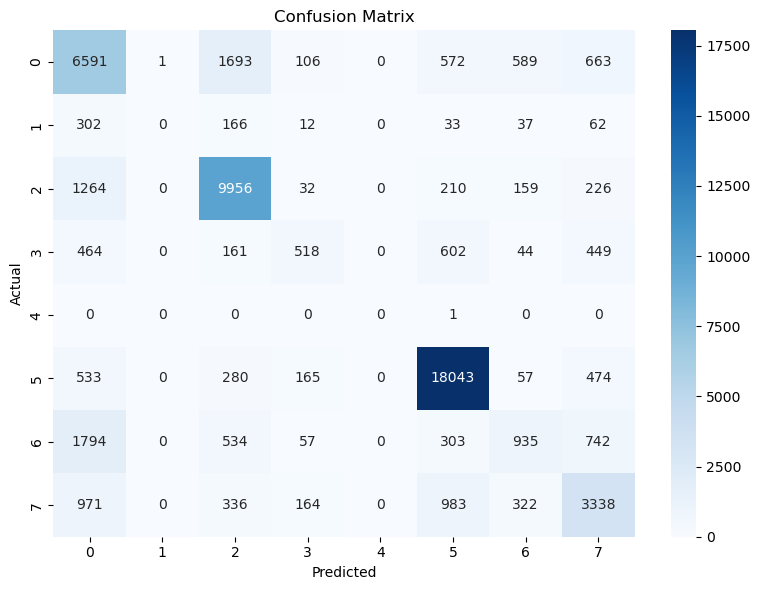


Per-Class Performance:
  0: Precision=0.553, Recall=0.645, F1=0.596
  1: Precision=0.000, Recall=0.000, F1=0.000
  2: Precision=0.758, Recall=0.840, F1=0.797
  3: Precision=0.491, Recall=0.231, F1=0.315
  4: Precision=0.000, Recall=0.000, F1=0.000
  5: Precision=0.870, Recall=0.923, F1=0.895
  6: Precision=0.436, Recall=0.214, F1=0.287
  7: Precision=0.561, Recall=0.546, F1=0.553


In [ ]:
# Plot training results
plot_training_results(train_acc_history, val_acc_history, train_loss_history, val_loss_history)
# Evaluate the best model
results = evaluate_best_model(
    model_class=GRU_bidirec_model,
    model_path="saved_models/best_gru_model_q8.pth", 
    test_gen=test_gen,
    criterion=criterion,
    device=device,
    task="Q8"
)
results_dir["GRU_bidirec"] = results

We got worse performance on Q8 as expected as we had very less data points for certain classes.
But, for 8 class classification, 71 % accuracy is decent.